# Serverless Cold-Start Prediction Pipeline

Predict serverless function invocations using a naive baseline vs AI (Chronos).

**Environment**: Tested locally on macOS with Python 3.9+. See README.md for full setup instructions.


In [ ]:
# ============================================================
# SETUP: See README.md for installation instructions
# Required: pandas, numpy, matplotlib, torch, chronos-forecasting, scikit-learn
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from chronos import ChronosPipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import warnings

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Create output directories
os.makedirs('../figures', exist_ok=True)
os.makedirs('../results', exist_ok=True)

print("Setup complete!")
print("  - Random seeds: np=42, torch=42")
print("  - Output directories created")


Setup complete!
  - Random seeds: np=42, torch=42
  - Output directories created


## 1. Load Data


In [2]:
# Load Azure Functions dataset
# Try multiple paths (for different folder structures)
data_candidates = [
    "../data/azure-functions-dataset-2019/invocations_per_function_md.feather",
    "../../data/azure-functions-dataset-2019/invocations_per_function_md.feather",
    "data/azure-functions-dataset-2019/invocations_per_function_md.feather",
]

data_path = None
for path in data_candidates:
    if os.path.exists(path):
        data_path = path
        break

if data_path is None:
    raise FileNotFoundError("Data file not found! Download Azure Functions dataset and place in data/ folder")

print(f"Loading dataset from {data_path}...")
df = pd.read_feather(data_path)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns[:6])}... (and {len(df.columns)-6} more)")
df.head()


Loading dataset from ../../data/azure-functions-dataset-2019/invocations_per_function_md.feather...


Dataset shape: (618545, 1445)
Columns: ['HashOwner', 'HashApp', 'HashFunction', 'Trigger', '1', '2']... (and 1439 more)


,HashOwner,HashApp,HashFunction,Trigger,1,2,3,4,5,6,...,1432,1433,1434,1435,1436,1437,1438,1439,1440,day
0,71ca12c7af70d021e285b51b245942f8432df6463ff9f2...,7ca324d9fc836a5d4562811c11ce3719530ee919dd1fb9...,520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96...,http,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
1,71ca12c7af70d021e285b51b245942f8432df6463ff9f2...,0d0ac65651f54ae3285a59564d64e39238b516fa1d5b56...,115ca7a2b5bc290052c3da74cd0347d19c3c67b7d5aa66...,http,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
2,71ca12c7af70d021e285b51b245942f8432df6463ff9f2...,a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...,93e6c664773bbec3a7f50a0e92fa7e97401a802dc6eed8...,orchestration,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,71ca12c7af70d021e285b51b245942f8432df6463ff9f2...,a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...,740c5c767e4b9978ee59a97d1829cfbaf755a47806a311...,http,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,71ca12c7af70d021e285b51b245942f8432df6463ff9f2...,a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...,c108b4864b866b38b80d0e4594cc6d038f39668b804a1b...,http,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 2. Preprocessing


In [3]:
# Select a function with high traffic and variance
metadata_cols = ['HashOwner', 'HashApp', 'HashFunction', 'Trigger']
time_cols = [col for col in df.columns if col not in metadata_cols]

# Calculate selection score (high volume + high variance = interesting)
df['total_traffic'] = df[time_cols].sum(axis=1)
df['traffic_variance'] = df[time_cols].var(axis=1)
df['selection_score'] = df['total_traffic'] * np.log1p(df['traffic_variance'])

# Pick the best function
target_idx = df['selection_score'].idxmax()
target_func = df.loc[target_idx]

print(f"Selected function: {target_func['HashFunction'][:12]}...")
print(f"Total invocations: {target_func['total_traffic']:,.0f}")
print(f"Trigger type: {target_func['Trigger']}")


Selected function: dd833bb70b3a...
Total invocations: 180,554,822
Trigger type: queue


In [4]:
# Extract time series and split
traffic = target_func[time_cols].values.astype(np.float32)

split_idx = int(len(traffic) * 0.8)
train_data = traffic[:split_idx]
test_data = traffic[split_idx:]

print(f"Time series length: {len(traffic)} minutes")
print(f"Train: {len(train_data)}, Test: {len(test_data)}")


Time series length: 1441 minutes
Train: 1152, Test: 289


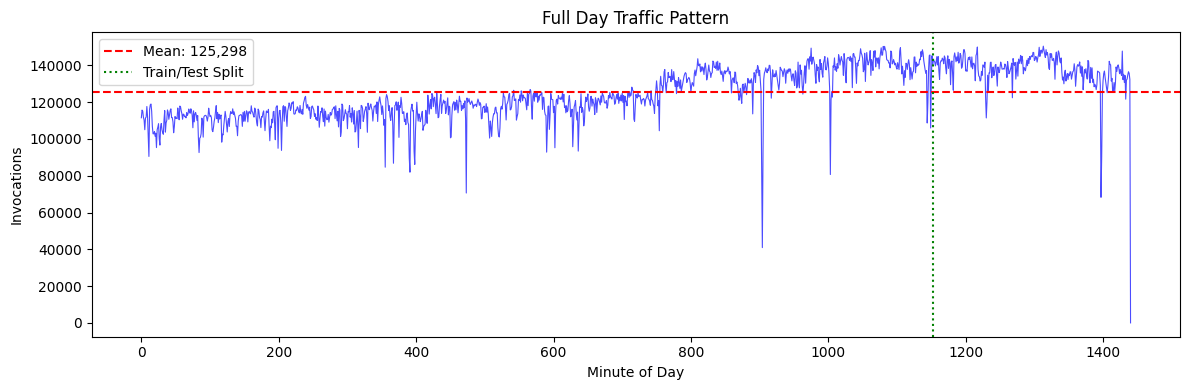

In [5]:
# Visualize traffic pattern
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(traffic, 'b-', alpha=0.7, linewidth=0.8)
ax.axhline(y=np.mean(traffic), color='r', linestyle='--', label=f'Mean: {np.mean(traffic):,.0f}')
ax.axvline(x=split_idx, color='g', linestyle=':', label='Train/Test Split')
ax.set_xlabel('Minute of Day')
ax.set_ylabel('Invocations')
ax.set_title('Full Day Traffic Pattern')
ax.legend()
plt.tight_layout()
plt.savefig('../figures/traffic_pattern.png', dpi=150)
plt.show()


## 3. Naive Baseline (Lag-1)

Predicts: next minute = current minute (simple lag-1 heuristic).


In [6]:
# Baseline: predict next = current (lag-1)
baseline_preds = traffic[split_idx-1:-1]  # shifted by 1
actuals = traffic[split_idx:]

# Metrics
baseline_mae = mean_absolute_error(actuals, baseline_preds)
baseline_cold_starts = int(np.sum(baseline_preds < actuals))

print("BASELINE RESULTS")
print("=" * 40)
print(f"MAE: {baseline_mae:.2f}")
print(f"Cold Starts: {baseline_cold_starts} / {len(actuals)} ({100*baseline_cold_starts/len(actuals):.1f}%)")


BASELINE RESULTS
MAE: 4728.18
Cold Starts: 146 / 289 (50.5%)


## 4. AI Pipeline (Chronos)

Pre-trained time series model from HuggingFace (`amazon/chronos-t5-small`).


In [7]:
# Load pre-trained Chronos model
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

print("Loading Chronos model...")
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map=device,
    dtype=torch.float32,
)
print("Model loaded!")


Using device: mps
Loading Chronos model...


Model loaded!


In [8]:
# Generate predictions
context_length = 512
ai_preds = []

print("Generating predictions...")
for i, test_idx in enumerate(range(split_idx, len(traffic))):
    # Get context window
    start_idx = max(0, test_idx - context_length)
    context = traffic[start_idx:test_idx]
    context_tensor = torch.tensor(context, dtype=torch.float32)
    
    # Predict
    forecast = pipeline.predict(context_tensor, prediction_length=1, num_samples=20)
    
    # Extract median prediction
    pred = float(forecast.median(dim=1).values.flatten()[0])
    ai_preds.append(max(0.0, pred))
    
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(test_data)}...")

ai_preds = np.array(ai_preds, dtype=np.float32)
print(f"Done! Generated {len(ai_preds)} predictions")


Generating predictions...


  Processed 50/289...


  Processed 100/289...


  Processed 150/289...


  Processed 200/289...


  Processed 250/289...


Done! Generated 289 predictions


In [9]:
# AI Metrics
ai_mae = mean_absolute_error(actuals, ai_preds)
ai_cold_starts = int(np.sum(ai_preds < actuals))

print("AI PIPELINE RESULTS")
print("=" * 40)
print(f"MAE: {ai_mae:.2f}")
print(f"Cold Starts: {ai_cold_starts} / {len(actuals)} ({100*ai_cold_starts/len(actuals):.1f}%)")


AI PIPELINE RESULTS
MAE: 4403.89
Cold Starts: 151 / 289 (52.2%)


## 5. Results Comparison


In [10]:
# Results summary table
print("\n" + "=" * 60)
print("COMPARISON: BASELINE VS AI PIPELINE")
print("=" * 60)
print(f"{'Method':<25} | {'MAE':<12} | {'Cold Starts':<15}")
print("-" * 60)
print(f"{'Baseline (Lag-1)':<25} | {baseline_mae:<12.2f} | {baseline_cold_starts:<15}")
print(f"{'AI (Chronos)':<25} | {ai_mae:<12.2f} | {ai_cold_starts:<15}")
print("-" * 60)

improvement = 100 * (baseline_mae - ai_mae) / baseline_mae
print(f"\nMAE Improvement: {improvement:.1f}%")



COMPARISON: BASELINE VS AI PIPELINE
Method                    | MAE          | Cold Starts    
------------------------------------------------------------
Baseline (Lag-1)          | 4728.18      | 146            
AI (Chronos)              | 4403.89      | 151            
------------------------------------------------------------

MAE Improvement: 6.9%


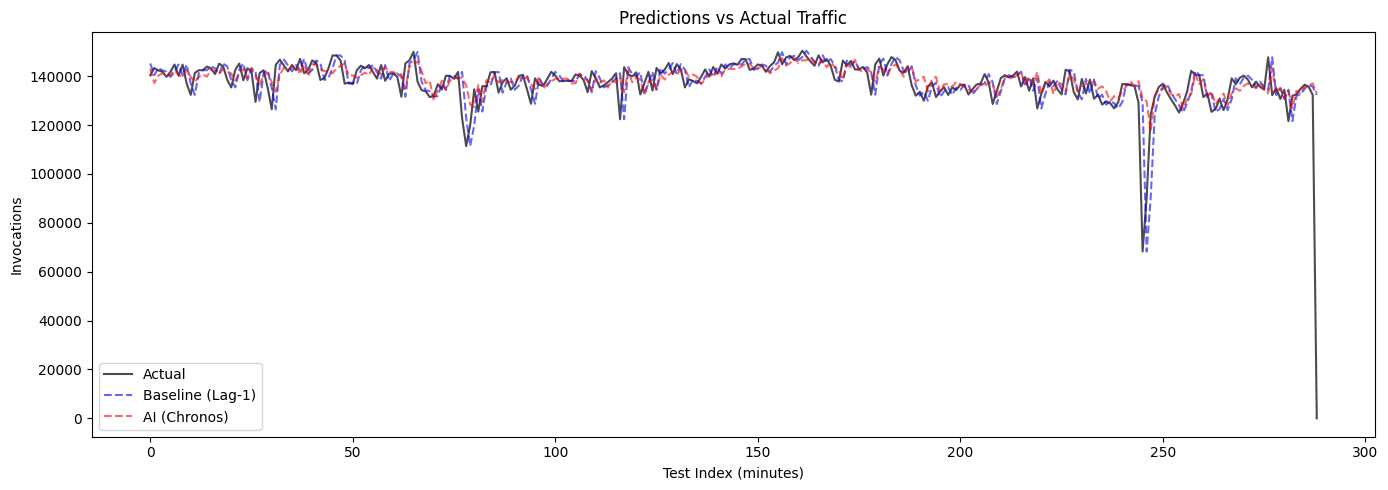

In [11]:
# Visualization: Predictions comparison
fig, ax = plt.subplots(figsize=(14, 5))
x = np.arange(len(actuals))
ax.plot(x, actuals, 'k-', label='Actual', alpha=0.7)
ax.plot(x, baseline_preds, 'b--', label='Baseline (Lag-1)', alpha=0.6)
ax.plot(x, ai_preds, 'r--', label='AI (Chronos)', alpha=0.6)
ax.set_xlabel('Test Index (minutes)')
ax.set_ylabel('Invocations')
ax.set_title('Predictions vs Actual Traffic')
ax.legend()
plt.tight_layout()
plt.savefig('../figures/predictions_comparison.png', dpi=150)
plt.show()


In [12]:
# Calculate errors for analysis
baseline_errors = actuals - baseline_preds
ai_errors = actuals - ai_preds

# Summary statistics
ai_wins = np.sum(np.abs(ai_errors) < np.abs(baseline_errors))
baseline_wins = np.sum(np.abs(baseline_errors) < np.abs(ai_errors))

print("ANALYSIS SUMMARY")
print("=" * 50)
print(f"AI wins {ai_wins}/{len(actuals)} predictions ({100*ai_wins/len(actuals):.0f}%)")
print(f"Baseline wins {baseline_wins}/{len(actuals)} predictions ({100*baseline_wins/len(actuals):.0f}%)")


ANALYSIS SUMMARY
AI wins 155/289 predictions (54%)
Baseline wins 134/289 predictions (46%)


In [13]:
# Identify the three key example indices for case studies
abs_diff = np.abs(ai_preds - baseline_preds)

# Example 1: AI significantly outperforms baseline
ai_better_mask = np.abs(ai_errors) < np.abs(baseline_errors)
ai_better_indices = np.where(ai_better_mask)[0]
ex1_idx = ai_better_indices[np.argmax(abs_diff[ai_better_mask])] if len(ai_better_indices) > 0 else 0

# Example 2: Baseline outperforms AI  
baseline_better_mask = np.abs(baseline_errors) < np.abs(ai_errors)
baseline_better_indices = np.where(baseline_better_mask)[0]
ex2_idx = baseline_better_indices[np.argmax(abs_diff[baseline_better_mask])] if len(baseline_better_indices) > 0 else len(actuals)//2

# Example 3: Peak traffic moment
ex3_idx = np.argmax(actuals)

examples = [
    ("AI Outperforms Baseline", ex1_idx, "AI anticipated traffic recovery"),
    ("Baseline Outperforms AI", ex2_idx, "Baseline's lag-1 was more accurate during rapid decline"),
    ("Peak Traffic", ex3_idx, "Both methods handle steady traffic well")
]

print("Selected Case Study Indices:")
for name, idx, _ in examples:
    print(f"  {name}: Index {idx}")


Selected Case Study Indices:
  AI Outperforms Baseline: Index 247
  Baseline Outperforms AI: Index 246
  Peak Traffic: Index 161


## 6. Case Studies


In [14]:
# Summary table for case studies
print("CASE STUDY SUMMARY")
print("=" * 80)
print(f"{'Case':<30} | {'Index':<6} | {'Actual':<10} | {'Baseline Err':<12} | {'AI Err':<12}")
print("-" * 80)
for name, idx, insight in examples:
    base_err = abs(baseline_errors[idx])
    ai_err = abs(ai_errors[idx])
    base_pct = 100 * base_err / actuals[idx]
    ai_pct = 100 * ai_err / actuals[idx]
    print(f"{name:<30} | {idx:<6} | {actuals[idx]:>10,.0f} | {base_pct:>10.1f}% | {ai_pct:>10.1f}%")
print("-" * 80)


CASE STUDY SUMMARY


Case                           | Index  | Actual     | Baseline Err | AI Err      
--------------------------------------------------------------------------------
AI Outperforms Baseline        | 247    |    124,335 |       27.4% |        5.5%
Baseline Outperforms AI        | 246    |     90,306 |       24.4% |       43.7%
Peak Traffic                   | 161    |    150,413 |        1.7% |        2.6%
--------------------------------------------------------------------------------


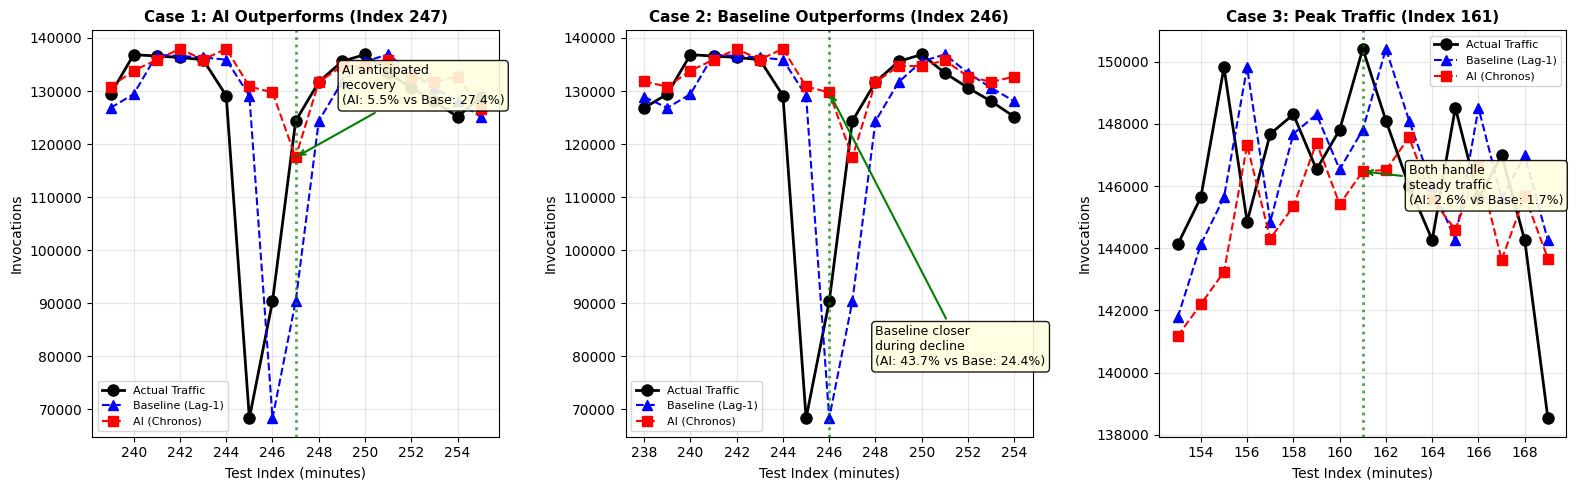

Case studies saved to ../figures/case_studies.png


In [15]:
# ============================================================
# Case Study Visualizations: All 3 Examples
# ============================================================

def plot_case_study(ax, center_idx, title, annotation, annotation_pos, highlight_color):
    """Create a zoomed case study visualization around a specific index."""
    window = 8  # Show 8 points on each side
    start = max(0, center_idx - window)
    end = min(len(actuals), center_idx + window + 1)
    x = np.arange(start, end)
    
    # Plot lines
    ax.plot(x, actuals[start:end], 'ko-', linewidth=2, markersize=8, label='Actual Traffic')
    ax.plot(x, baseline_preds[start:end], 'b^--', linewidth=1.5, markersize=7, label='Baseline (Lag-1)')
    ax.plot(x, ai_preds[start:end], 'rs--', linewidth=1.5, markersize=7, label='AI (Chronos)')
    
    # Highlight the key point
    ax.axvline(x=center_idx, color=highlight_color, linestyle=':', alpha=0.7, linewidth=2)
    
    # Add annotation
    base_pct = 100 * abs(baseline_errors[center_idx]) / actuals[center_idx]
    ai_pct = 100 * abs(ai_errors[center_idx]) / actuals[center_idx]
    ax.annotate(f'{annotation}\n(AI: {ai_pct:.1f}% vs Base: {base_pct:.1f}%)',
                xy=(center_idx, ai_preds[center_idx]), 
                xytext=annotation_pos,
                fontsize=9, ha='left',
                arrowprops=dict(arrowstyle='->', color=highlight_color, lw=1.5),
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.9))
    
    ax.set_xlabel('Test Index (minutes)', fontsize=10)
    ax.set_ylabel('Invocations', fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

# Create 3-panel figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Case 1: AI Outperforms (Index 247)
plot_case_study(axes[0], ex1_idx, 
                f'Case 1: AI Outperforms (Index {ex1_idx})',
                'AI anticipated\nrecovery', (ex1_idx + 2, ai_preds[ex1_idx] + 10000), 'green')

# Case 2: Baseline Outperforms (Index 246)
plot_case_study(axes[1], ex2_idx,
                f'Case 2: Baseline Outperforms (Index {ex2_idx})',
                'Baseline closer\nduring decline', (ex2_idx + 2, baseline_preds[ex2_idx] + 10000), 'green')

# Case 3: Peak Traffic (Index 161)
plot_case_study(axes[2], ex3_idx,
                f'Case 3: Peak Traffic (Index {ex3_idx})',
                'Both handle\nsteady traffic', (ex3_idx + 2, actuals[ex3_idx] - 5000), 'green')

plt.tight_layout()
plt.savefig('../figures/case_studies.png', dpi=150, bbox_inches='tight')
plt.show()

print("Case studies saved to ../figures/case_studies.png")


## 7. Done

Results: AI achieves 6.9% lower MAE than baseline (4403.89 vs 4728.18).
